# Load packages

In [169]:
# Packages
import os, csv
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from nervaluate import Evaluator
import itertools
from IPython.display import display
from utils import preprocess_rater, list_overlap, average_score, rater_avg_df

# Load data and preprocess

In [170]:
def prepare_NER(df_rater):
    """Function to prepare NER tags for a single rater for interrater calculations.

    Args:
        df_rater (pd.DataFrame): preprocessed dataframe of single rater

    Returns:
        pd.DataFrame: dataframe with preprocessed NER tags, one row per token, with NER tags
    """
    irrelevant_columns = [
        i
        for i in [
            "meta",
            "_input_hash",
            "_task_hash",
            "_is_binary",
            "_view_id",
            "answer",
            "_timestamp",
        ]
        if i in df_rater.columns
    ]
    df_clean = df_rater.drop(irrelevant_columns, axis=1)#.drop(["meta", "_input_hash", "_task_hash", "_is_binary", "_view_id", "answer", "_timestamp"], axis=1)
    # Put each token on its own line
    exploded_tokens = df_clean.explode("tokens", ignore_index=True)
    # Normalise tokens column (expanding json format)
    normalised_tokens = pd.json_normalize(exploded_tokens["tokens"]).add_prefix("tokens_")
    # Add normalised columns to the data and delete old spans
    tokens = pd.concat([exploded_tokens, normalised_tokens], axis=1)

    # Put each rated NE on its own line
    exploded_spans = tokens.explode("spans", ignore_index=True)
    # Normalise span column
    normalised_spans = pd.json_normalize(exploded_spans["spans"]).add_prefix("spans_")
    # Normalise spans so that the info is in the dataframe
    spans = pd.concat([exploded_spans, normalised_spans], axis=1)

    # Only keep one row for each NE, i.e. only keep the rows where the token is within in the span of the NE 
    ne_tokens = spans[(spans.tokens_id >= spans.spans_token_start) & (spans.tokens_id <= spans.spans_token_end)]
    #print("Number of NEs for rater:", ne_tokens.shape)
    ne_tokens = ne_tokens.drop(["spans", "tokens"], axis=1)

    return pd.merge(tokens, ne_tokens, on=['rater_id', 'doc', 'tokens_text', 'tokens_start', 'tokens_end', 'tokens_id', 'tokens_ws'], how="outer") 

In [171]:
raterdf_list = []
NERdf_list = []

for id in range(1, 11):
    if not id == 2 and not id == 10:
        raw_data = pd.read_json(f"../data/interrater_final_data/{id}.jsonl", lines=True)

        # List of preprocessed data
        preprocessed_df = preprocess_rater(raw_data, id)
        raterdf_list.append(preprocessed_df)

        # List of NER data
        NER_df = prepare_NER(preprocessed_df)
        NERdf_list.append(NER_df)

model_raw = pd.read_json("../data/interrater_final_data/gold-multi.jsonl", lines=True)
model_preprocessed = preprocess_rater(model_raw, "gold")
raterdf_list.append(model_preprocessed)
model_NER = prepare_NER(model_preprocessed)
NERdf_list.append(model_NER)

In [172]:
labels = sorted(list(set(model_NER.fillna("NOT TAGGED", inplace=False)["spans_label"].tolist())))
labels

['CARDINAL',
 'DATE',
 'EVENT',
 'FACILITY',
 'GPE',
 'LAW',
 'LOCATION',
 'MONEY',
 'NORP',
 'NOT TAGGED',
 'ORDINAL',
 'ORGANIZATION',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK OF ART']

### After loading data, we now have the following format, in which:
- Each element is a dataframe
- raterdf_list has entire doc in each row, with a list of tokens in each
    - spans, have information on where token is located and any NER-tag
- NERdf_list has single tokens in each row
    - spans_label, has information on any potential token-tag

In [173]:
print(raterdf_list[0]["doc"][0])
print(raterdf_list[0]["spans"][0])
print(raterdf_list[0]["spans"][0][0]["label"])
raterdf_list[0].head(2)

Hvordan kan statsministeren kalde børn,der er født på danske hospitaler for indvandrerdrenge!
[{'start': 54, 'end': 60, 'label': 'NORP', 'token_start': 10, 'token_end': 10}]
NORP


,rater_id,doc,tokens,_is_binary,_view_id,answer,_timestamp,spans
0,1,"Hvordan kan statsministeren kalde børn,der er ...","[{'text': 'Hvordan', 'start': 0, 'end': 7, 'id...",False,ner_manual,accept,1635322276,"[{'start': 54, 'end': 60, 'label': 'NORP', 'to..."
1,1,Det her er jo håbløst #dkpol https://t.co/e7h...,"[{'text': 'Det', 'start': 0, 'end': 3, 'id': 0...",False,ner_manual,accept,1635322276,[]


# Explore interrater reliability

### How do the documents overlap between raters?

In [174]:
# Get rater ids
raters = [df.rater_id[1] for df in raterdf_list]
print(raters)

[1, 3, 4, 5, 6, 7, 8, 9, 'gold']


In [175]:
# Check document overlap of annotators
overlap_list = []
for i in range(len(raters)):
    raterA_df = raterdf_list[i]
    overlap_list.append([len(list_overlap(raterA_df.doc, raterB_df.doc)) for raterB_df in raterdf_list])

# Create dataframe for text overlap
print("OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS")
overlap_df = pd.DataFrame(data=np.array(overlap_list), index=raters, columns=pd.Index(raters, name="Rater"))
overlap_df

#overlap_df.to_csv("../../output/NER/NER_doc_overlap.csv")

OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS


Rater,1,3,4,5,6,7,8,9,gold
1,629,587,531,597,605,578,537,582,617
3,587,630,545,590,601,579,534,579,626
4,531,545,581,532,544,518,472,525,574
5,597,590,532,630,602,588,536,584,624
6,605,601,544,602,647,587,547,594,638
7,578,579,518,588,587,607,526,575,603
8,537,534,472,536,547,526,611,571,605
9,582,579,525,584,594,575,571,684,659
gold,617,626,574,624,638,603,605,659,750


### How much do the raters agree with one another on the NER tagging 
- This includes tokens that are not tagged
- This is calculated on a token per token level
- Given:
    - rater_1 "Dette er \[Kongeriget Danmark\](GPE)"
    - rater_2 "Dette er Kongeriget \[Danmark\](GPE)"
    - They will have 3/4 flat agreement

In [176]:
# The Cohens Kappa is thus computed based off the following confusion matrix (for the example given above)
Rater1 = pd.Series(["NO TAG", "NO TAG", "GPE", "GPE"],name="Rater1")
Rater2 = pd.Series(["NO TAG", "NO TAG", "NO TAG", "GPE"],name="Rater2")
pd.crosstab(Rater1, Rater2,margins=True)

Rater2,GPE,NO TAG,All
Rater1,,,
GPE,1,1,2
NO TAG,0,2,2
All,1,3,4


In [177]:
kappa_list = []
token_overlap_list = []

# For each rater
for raterA in range(len(raters)):
    
    kappa_rater = []
    token_overlap_rater = []

    # Create pair with another rater
    for raterB in range(len(raters)):

        # Merge dataframes on tokens
        df_pair = pd.merge(NERdf_list[raterA], NERdf_list[raterB], on=["doc", "tokens_text", "tokens_start", "tokens_end"], suffixes=["_raterA", "_raterB"])
        df_pair[["spans_label_raterA", "spans_label_raterB"]] = df_pair[["spans_label_raterA", "spans_label_raterB"]].fillna("")
        
        # Get the number of overlapping tokens
        token_overlap = len(df_pair)
        token_overlap_rater.append(token_overlap)
        
        # Get kappa
        kappa = cohen_kappa_score(df_pair.spans_label_raterA, df_pair.spans_label_raterB)
        kappa_rater.append(kappa)

    kappa_list.append(kappa_rater)
    token_overlap_list.append(token_overlap_rater)

kappa_array = np.array(kappa_list)
token_overlap_array = np.array(token_overlap_list)

In [178]:
kappa_df = pd.DataFrame(data=kappa_array, index=raters, columns=pd.Index(raters, name="Rater"))

# Print average kappa across pairs
print("AVERAGE KAPPA ACROSS PAIRS")
average_score(kappa_df)

# Print df with pairwise scores
print("\nPAIRWISE KAPPAS")
kappa_df_avg = rater_avg_df(kappa_df).round(2)
kappa_df_avg

AVERAGE KAPPA ACROSS PAIRS
Mean (SD) Score: 0.9619851842584137 (0.010910150175568376)

PAIRWISE KAPPAS


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.96,0.96,0.96,0.97,0.96,0.94,0.96,0.97,0.96
3,0.96,1.00,0.97,0.96,0.96,0.98,0.95,0.97,0.97,0.96
4,0.96,0.97,1.00,0.95,0.97,0.98,0.96,0.98,0.96,0.97
5,0.96,0.96,0.95,1.00,0.97,0.96,0.94,0.96,0.97,0.96
6,0.97,0.96,0.97,0.97,1.00,0.97,0.95,0.97,0.97,0.97
7,0.96,0.98,0.98,0.96,0.97,1.00,0.95,0.98,0.96,0.97
8,0.94,0.95,0.96,0.94,0.95,0.95,1.00,0.95,0.95,0.95
9,0.96,0.97,0.98,0.96,0.97,0.98,0.95,1.00,0.95,0.96
gold,0.97,0.97,0.96,0.97,0.97,0.96,0.95,0.95,1.00,0.96


In [179]:
kappa_df_avg.to_csv("../output/DANSK_final_interrater/kappa_also_non_annotated.csv")

### How much do the raters agree with one another on the NER-tagging (excluding cases in which neither tagged a given word as a NE )

In [180]:
print("PAIRWISE TOKEN OVERLAP (USED FOR CALCULATION OF KAPPAS)")
token_overlap_df = pd.DataFrame(data=token_overlap_array, index=raters, columns=pd.Index(raters, name="Rater"))
token_overlap_df

#token_overlap_df.to_csv("../../output/NER/NER_token_overlap_all.csv")

PAIRWISE TOKEN OVERLAP (USED FOR CALCULATION OF KAPPAS)


Rater,1,3,4,5,6,7,8,9,gold
1,6063,5856,5335,5892,5902,5805,5691,5744,5973
3,5856,6037,5409,5869,5916,5832,5728,5764,6013
4,5335,5409,5567,5381,5386,5292,5190,5311,5540
5,5892,5869,5381,6088,5898,5861,5692,5755,6061
6,5902,5916,5386,5898,6051,5857,5750,5806,6017
7,5805,5832,5292,5861,5857,5951,5665,5759,5929
8,5691,5728,5190,5692,5750,5665,6100,5859,6079
9,5744,5764,5311,5755,5806,5759,5859,6347,6138
gold,5973,6013,5540,6061,6017,5929,6079,6138,6646


In [181]:
kappa_list = []
token_overlap_list = []

# For each rater
for raterA in range(0, len(raters)):
    
    kappa_rater = []
    token_overlap_rater = []

    # Create pair with other raters
    for raterB in range(0, len(raters)):

        # Merge data of pairs on tokens
        df_pair = pd.merge(NERdf_list[raterA], NERdf_list[raterB], on=["doc", "tokens_text", "tokens_start", "tokens_end"], suffixes=["_raterA", "_raterB"])
        # Keep only if annotated by at least one rater
        df_annotated = df_pair.dropna(subset=["spans_label_raterA", "spans_label_raterB"], how="all").reset_index().fillna("")

        # Get number of overlapping tokens
        token_overlap = len(df_annotated)
        token_overlap_rater.append(token_overlap)
        # Get kappa
        kappa = cohen_kappa_score(df_annotated.spans_label_raterA, df_annotated.spans_label_raterB)
        kappa_rater.append(kappa)

    # Append to list
    kappa_list.append(kappa_rater)
    token_overlap_list.append(token_overlap_rater)

kappa_array = np.array(kappa_list)
token_overlap_array = np.array(token_overlap_list)

In [182]:
kappa_df = pd.DataFrame(data=kappa_array, index=raters, columns=pd.Index(raters, name="Rater"))

print("AVERAGE KAPPA ACROSS PAIRS")
average_score(kappa_df)
print("\nPAIRWISE KAPPAS")
kappa_df_avg = rater_avg_df(kappa_df).round(2)
kappa_df_avg


AVERAGE KAPPA ACROSS PAIRS
Mean (SD) Score: 0.9198888049188712 (0.02186108041354796)

PAIRWISE KAPPAS


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.91,0.92,0.92,0.93,0.91,0.87,0.92,0.94,0.92
3,0.91,1.00,0.94,0.92,0.92,0.95,0.89,0.93,0.93,0.93
4,0.92,0.94,1.00,0.90,0.93,0.96,0.92,0.96,0.93,0.93
5,0.92,0.92,0.90,1.00,0.94,0.91,0.88,0.91,0.93,0.91
6,0.93,0.92,0.93,0.94,1.00,0.93,0.90,0.93,0.95,0.93
7,0.91,0.95,0.96,0.91,0.93,1.00,0.90,0.95,0.92,0.93
8,0.87,0.89,0.92,0.88,0.90,0.90,1.00,0.90,0.89,0.89
9,0.92,0.93,0.96,0.91,0.93,0.95,0.90,1.00,0.90,0.92
gold,0.94,0.93,0.93,0.93,0.95,0.92,0.89,0.90,1.00,0.92


In [183]:
kappa_df_avg.to_csv("../output/DANSK_final_interrater/kappa_annotated.csv")

In [184]:
list(kappa_df_avg.index)

[1, 3, 4, 5, 6, 7, 8, 9, 'gold']

### Between raters, how similar did they tag overall?

- For information on the calculations, see: https://pypi.org/project/nervaluate/


In [185]:
f1_list = []
f1_tags_list = []

# For each rater
for raterA in range(0, len(raters)):
    
    f1_rater = []
    f1_tags_rater = []

    # Pair with other rater
    for raterB in range(0, len(raters)):

        # Prepare data
        raterA_data = NERdf_list[raterA].copy().drop_duplicates(subset="doc")
        raterB_data = NERdf_list[raterB].copy().drop_duplicates(subset="doc")
        pair = pd.merge(raterA_data, raterB_data, on="doc", suffixes=["_raterA", "_raterB"], how="inner")

        # Prepare labels
        raterA_labels = pair.spans_raterA.tolist()
        raterB_labels = pair.spans_raterB.tolist()
        all_labels = list(itertools.chain.from_iterable(raterA_labels + raterB_labels))
        label_set = list(set([d["label"] for d in all_labels if "label" in d]))

        # Get F1 scores
        evaluator = Evaluator(raterA_labels, raterB_labels, tags=label_set)
        results, results_by_tag = evaluator.evaluate()

        # Append to list
        f1_rater.append(results)
        f1_tags_rater.append(results_by_tag)

    f1_list.append(f1_rater)
    f1_tags_list.append(f1_tags_rater)

In [186]:
# Extract separate f1 scores from results and store in arrays in dict
f1_dict = {
    "STRICT": np.array([[f1B["strict"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "EXACT": np.array([[f1B["exact"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "PARTIAL": np.array([[f1B["partial"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "ENT_TYPE": np.array([[f1B["ent_type"]["f1"] for f1B in f1A] for f1A in f1_list])
}

# Print results for each type of F1 Score
for type in f1_dict.keys():

    type_df = pd.DataFrame(data=f1_dict[type], index=raters, columns=pd.Index(raters, name="Rater"))

    print(f"AVERAGE F1 SCORE ON {type} MATCH")
    average_score(type_df)

    print(f"\nPAIRWISE F1 SCORE ON {type} MATCH")
    type_df_avg = rater_avg_df(type_df).round(2)
    display(type_df_avg)

    #type_df_avg.to_csv(f"../../output/NER/NER_F1_{type}.csv")

AVERAGE F1 SCORE ON STRICT MATCH
Mean (SD) Score: 0.9540166474936588 (0.01074887397438972)

PAIRWISE F1 SCORE ON STRICT MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.96,0.96,0.96,0.96,0.96,0.94,0.96,0.96,0.96
3,0.96,1.00,0.96,0.95,0.95,0.97,0.93,0.95,0.96,0.95
4,0.96,0.96,1.00,0.95,0.96,0.97,0.95,0.97,0.96,0.96
5,0.96,0.95,0.95,1.00,0.96,0.95,0.94,0.96,0.96,0.95
6,0.96,0.95,0.96,0.96,1.00,0.96,0.93,0.96,0.95,0.95
7,0.96,0.97,0.97,0.95,0.96,1.00,0.94,0.97,0.97,0.96
8,0.94,0.93,0.95,0.94,0.93,0.94,1.00,0.94,0.93,0.94
9,0.96,0.95,0.97,0.96,0.96,0.97,0.94,1.00,0.95,0.96
gold,0.96,0.96,0.96,0.96,0.95,0.97,0.93,0.95,1.00,0.95


AVERAGE F1 SCORE ON EXACT MATCH
Mean (SD) Score: 0.9626840672444901 (0.00883490254298126)

PAIRWISE F1 SCORE ON EXACT MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.97,0.97,0.96,0.96,0.97,0.95,0.97,0.97,0.97
3,0.97,1.00,0.97,0.96,0.96,0.98,0.95,0.96,0.96,0.96
4,0.97,0.97,1.00,0.95,0.96,0.98,0.96,0.98,0.97,0.97
5,0.96,0.96,0.95,1.00,0.97,0.97,0.95,0.96,0.96,0.96
6,0.96,0.96,0.96,0.97,1.00,0.96,0.94,0.96,0.96,0.96
7,0.97,0.98,0.98,0.97,0.96,1.00,0.96,0.97,0.97,0.97
8,0.95,0.95,0.96,0.95,0.94,0.96,1.00,0.95,0.95,0.95
9,0.97,0.96,0.98,0.96,0.96,0.97,0.95,1.00,0.96,0.96
gold,0.97,0.96,0.97,0.96,0.96,0.97,0.95,0.96,1.00,0.96


AVERAGE F1 SCORE ON PARTIAL MATCH
Mean (SD) Score: 0.9674294549960535 (0.007968812776922633)

PAIRWISE F1 SCORE ON PARTIAL MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.97,0.97,0.97,0.97,0.97,0.95,0.97,0.98,0.97
3,0.97,1.00,0.97,0.96,0.97,0.98,0.95,0.97,0.97,0.97
4,0.97,0.97,1.00,0.96,0.97,0.98,0.97,0.98,0.97,0.97
5,0.97,0.96,0.96,1.00,0.97,0.97,0.96,0.96,0.97,0.96
6,0.97,0.97,0.97,0.97,1.00,0.97,0.95,0.97,0.97,0.97
7,0.97,0.98,0.98,0.97,0.97,1.00,0.96,0.98,0.98,0.97
8,0.95,0.95,0.97,0.96,0.95,0.96,1.00,0.96,0.96,0.96
9,0.97,0.97,0.98,0.96,0.97,0.98,0.96,1.00,0.97,0.97
gold,0.98,0.97,0.97,0.97,0.97,0.98,0.96,0.97,1.00,0.97


AVERAGE F1 SCORE ON ENT_TYPE MATCH
Mean (SD) Score: 0.9579974874175247 (0.010510289768263126)

PAIRWISE F1 SCORE ON ENT_TYPE MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.96,0.96,0.96,0.97,0.96,0.94,0.97,0.97,0.96
3,0.96,1.00,0.96,0.96,0.96,0.97,0.93,0.96,0.97,0.96
4,0.96,0.96,1.00,0.95,0.96,0.97,0.95,0.97,0.96,0.96
5,0.96,0.96,0.95,1.00,0.96,0.95,0.95,0.96,0.97,0.96
6,0.97,0.96,0.96,0.96,1.00,0.96,0.95,0.96,0.97,0.96
7,0.96,0.97,0.97,0.95,0.96,1.00,0.94,0.97,0.97,0.96
8,0.94,0.93,0.95,0.95,0.95,0.94,1.00,0.94,0.94,0.94
9,0.97,0.96,0.97,0.96,0.96,0.97,0.94,1.00,0.95,0.96
gold,0.97,0.97,0.96,0.97,0.97,0.97,0.94,0.95,1.00,0.96


### Between raters, how similar did they tag for each of the individual NER groups?

- For information on the calculations, see: https://pypi.org/project/nervaluate/


In [187]:
# Get unique tags across raters
tags = []
for rater in NERdf_list:
    tags = tags + rater["spans_label"].to_list()
unique_tags = list(set(tags))

In [188]:
# Get number of annotations by tag by rater
rater_tag_counts = {}

# For each rater count the number of tags
for rater in range(len(raters)):
    tag_counts = NERdf_list[rater].value_counts("spans_label")
    rater_tag_counts[NERdf_list[rater]["rater_id"][0]] = tag_counts

print("TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER")
NER_tag_counts = pd.DataFrame(rater_tag_counts).fillna(0).astype(int)
display(NER_tag_counts)

#NER_tag_counts.to_csv("../../output/NER/NER_tag_counts.csv")

TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER


,1,3,4,5,6,7,8,9,gold
spans_label,,,,,,,,,
CARDINAL,38,46,35,29,42,33,34,26,50
DATE,87,77,72,85,87,53,80,57,111
EVENT,15,15,16,15,15,15,16,15,16
FACILITY,14,18,19,16,14,18,15,15,18
GPE,31,33,30,32,32,32,32,32,33
LAW,36,36,38,38,36,35,35,37,43
LOCATION,3,3,5,4,3,4,4,3,4
MONEY,16,16,16,16,16,16,16,16,16
NORP,54,55,52,53,52,52,59,52,52


In [189]:
def extract_tag_f1(f1_type, tag, results_tags_list):
    """Function to extract type of F1 score for specific tag.

    Args:
        f1_type (str): "strict", "exact", "type" or "partial"
        tag (str): NER tag
        results_tags_list (list): list of all results

    Returns:
        list: List of list of scores for each rater
    """
    scores = []
    # For each rater
    for raterA in results_tags_list:
        raterA_scores = []
        # And each pair rater 
        for raterB in raterA:
            # Get the F1 score
            if tag in raterB.keys():
                tag_scores = raterB[str(tag)][f1_type]["f1"]
            else:
                tag_scores = np.nan
                # Append to rater scores
            raterA_scores.append(tag_scores)
        # Append to all scores
        scores.append(raterA_scores)
        
    return scores

In [190]:
# Get strict F1 scores by tag
tag_f1_dict = {}
tag_avg_dict = {}

# For each tag get the strict f1 score from the results
for tag in unique_tags:
    tag_f1 = extract_tag_f1("strict", tag, f1_tags_list)
    # Pairwise f1 scores for tag
    tag_f1_dict[tag] = pd.DataFrame(tag_f1).round(2)
    # Averaged f1 scores for tag
    tag_avg_dict[tag] = average_score(pd.DataFrame(tag_f1), print_score=False)

print("AVERAGE STRICT F1-SCORE BY TAG")
tag_f1_avg = pd.DataFrame(tag_avg_dict, index=["mean", "sd"]).T.round(2).sort_index()
display(tag_f1_avg)


AVERAGE STRICT F1-SCORE BY TAG


,mean,sd
CARDINAL,0.93,0.06
DATE,0.86,0.08
EVENT,0.97,0.03
FACILITY,0.89,0.09
GPE,0.99,0.01
LAW,0.92,0.08
LOCATION,0.87,0.13
MONEY,1.00,0.00
NORP,0.96,0.02
ORDINAL,0.88,0.13


In [191]:

#tag_f1_avg.to_csv("../output/interrater/including_dansk/NER_F1TAG_STRICT.csv")

AVERAGE STRICT F1-SCORE BY TAG AND RATER
['CARDINAL', 'DATE', 'EVENT', 'FACILITY', 'GPE', 'LAW', 'LOCATION', 'MONEY', 'NORP', 'ORDINAL', 'ORGANIZATION', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK OF ART', nan]


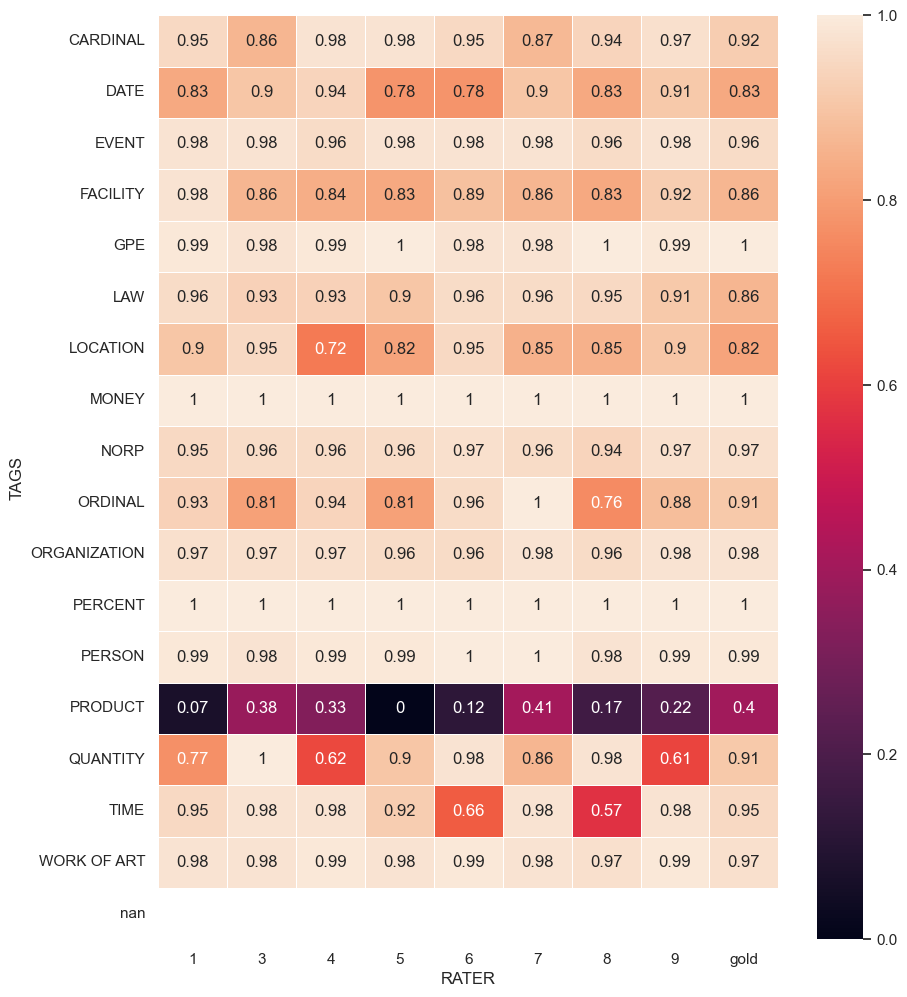

In [192]:
# Get F1 Scores by tag and rater
rater_avgs = []
# For all tags (exc)
for tag in unique_tags:
    # Extract f1 scores for tag
    tag_f1 = tag_f1_dict[tag]
    # Get the rater averages
    rater_avgs.append(rater_avg_df(tag_f1)["rater_avg"].tolist()) 
# Store in dataframe and sort
df = pd.DataFrame(rater_avgs, index = unique_tags)

# Sort by index name
df = df.sort_index()
df.columns = [1,3,4,5,6,7,8,9,"gold"]

# Create matrix
print("AVERAGE STRICT F1-SCORE BY TAG AND RATER")
plt.figure(figsize=(10,12))
with sns.axes_style("white"):
    s = sns.heatmap(np.array(df), xticklabels=[1,3,4,5,6,7,8,9,"gold"], yticklabels=df.index, annot=True, linewidths=0.5, vmax=1.0, cbar=True)
    s.set(ylabel='TAGS', xlabel='RATER');
print(list(df.index))

In [193]:
df

,1,3,4,5,6,7,8,9,gold
CARDINAL,0.95,0.86,0.98,0.98,0.95,0.87,0.94,0.97,0.92
DATE,0.83,0.90,0.94,0.78,0.78,0.90,0.83,0.91,0.83
EVENT,0.98,0.98,0.96,0.98,0.98,0.98,0.96,0.98,0.96
FACILITY,0.98,0.86,0.84,0.83,0.89,0.86,0.83,0.92,0.86
GPE,0.99,0.98,0.99,1.00,0.98,0.98,1.00,0.99,1.00
LAW,0.96,0.93,0.93,0.90,0.96,0.96,0.95,0.91,0.86
LOCATION,0.90,0.95,0.72,0.82,0.95,0.85,0.85,0.90,0.82
MONEY,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
NORP,0.95,0.96,0.96,0.96,0.97,0.96,0.94,0.97,0.97
ORDINAL,0.93,0.81,0.94,0.81,0.96,1.00,0.76,0.88,0.91


In [194]:
df.to_csv("../output/DANSK_final_interrater/avg_f1_strict.csv")

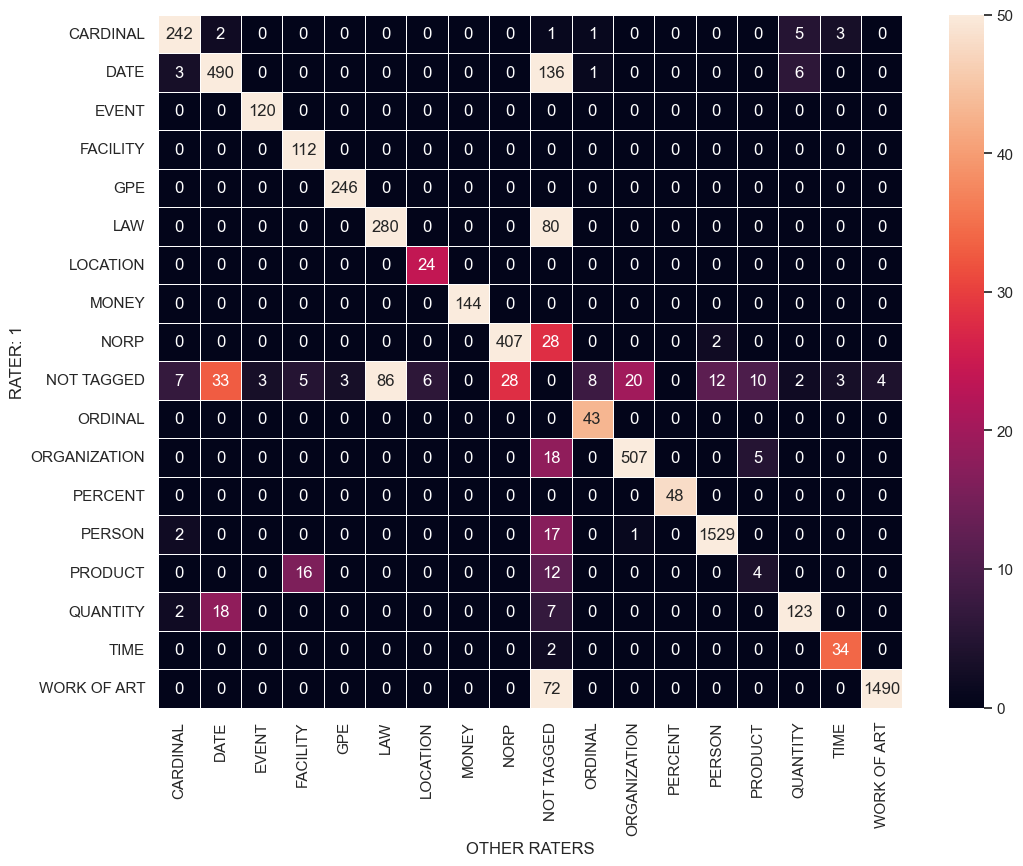

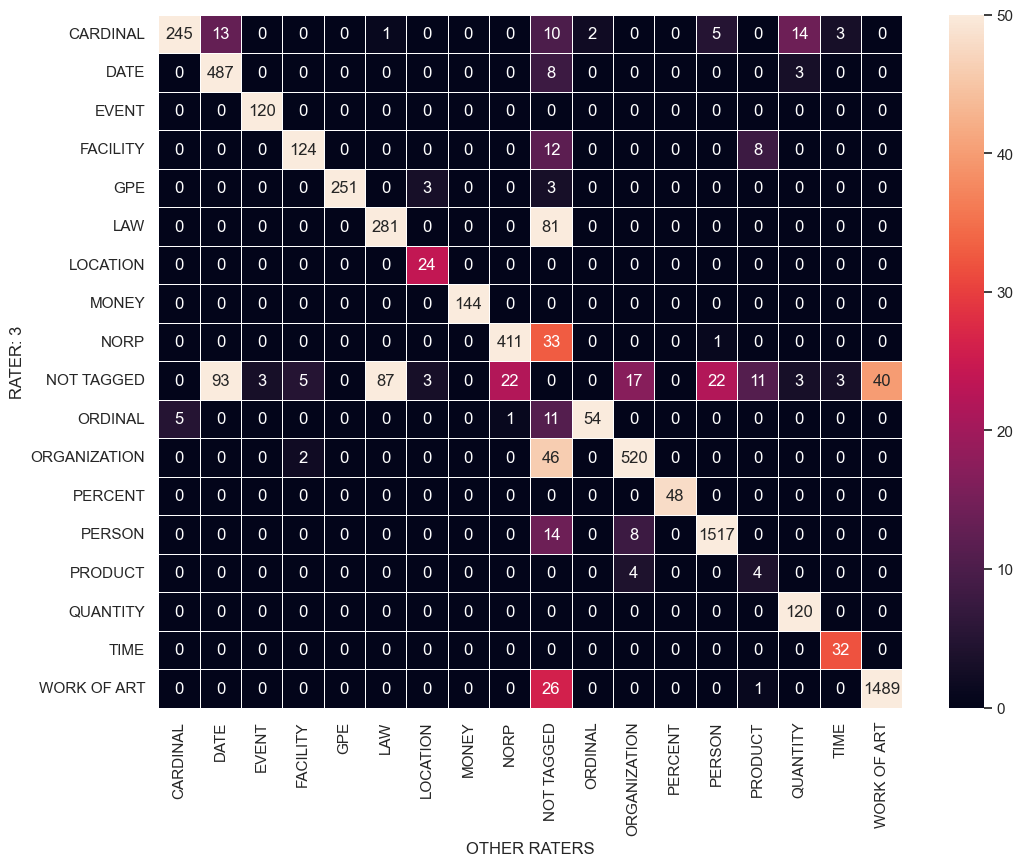

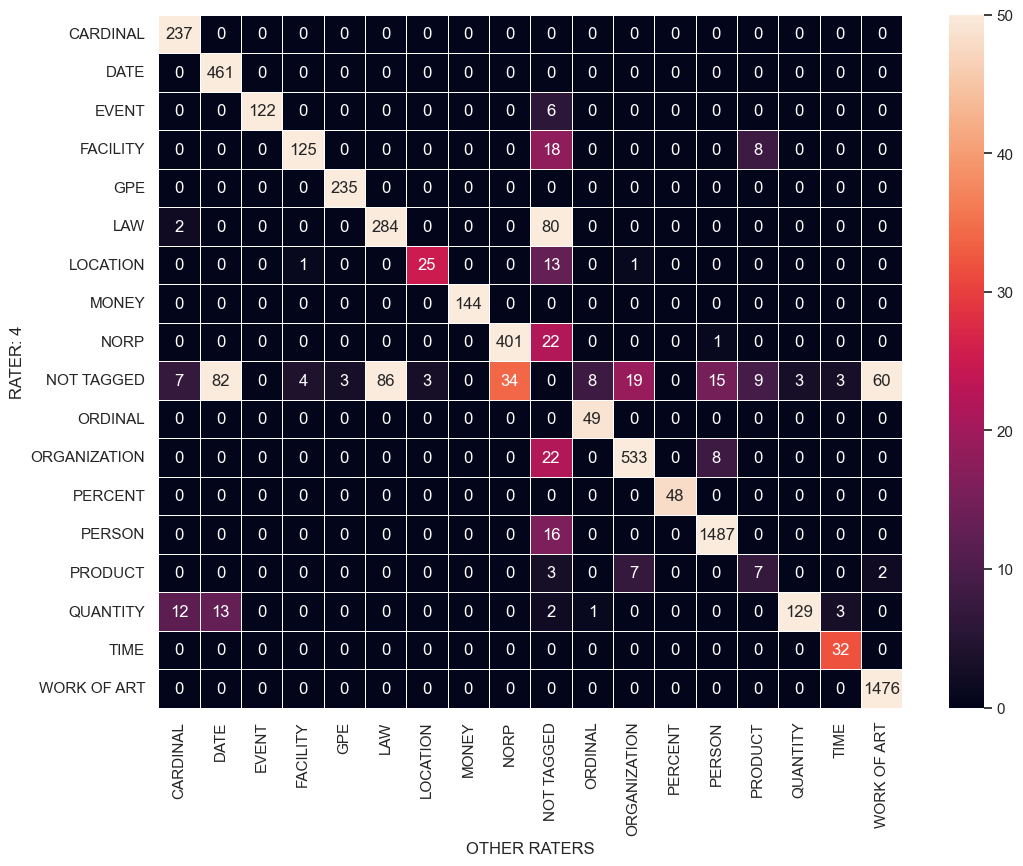

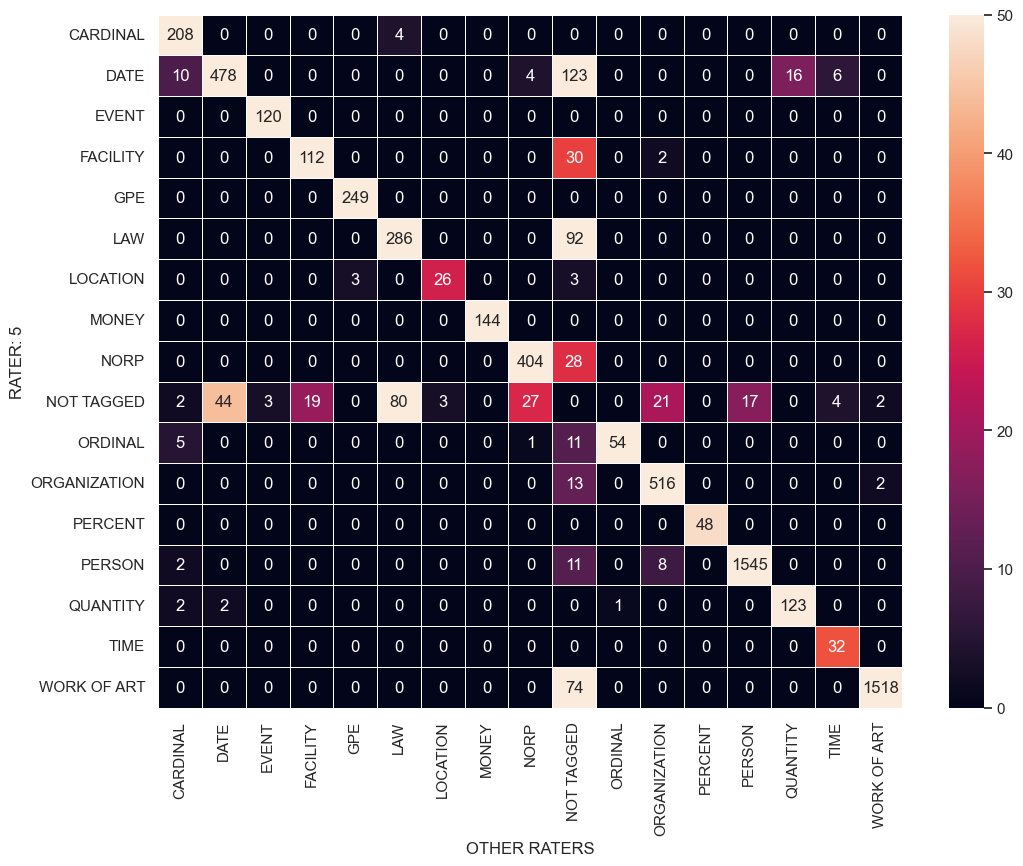

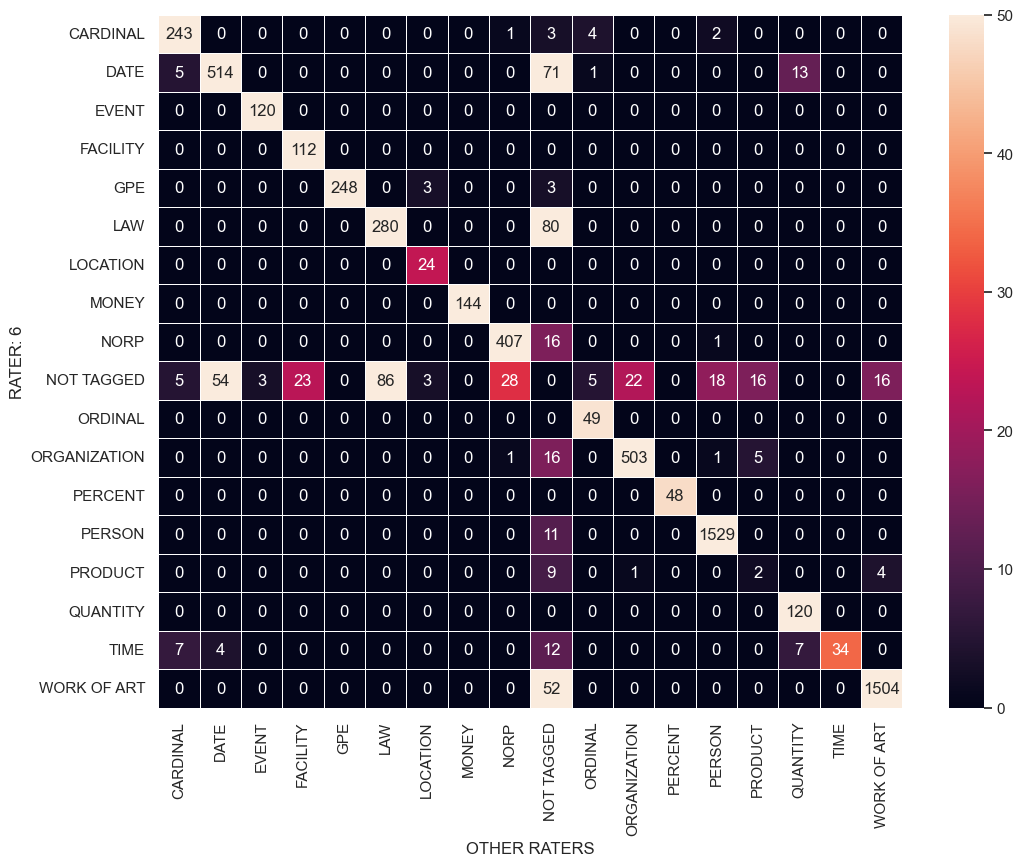

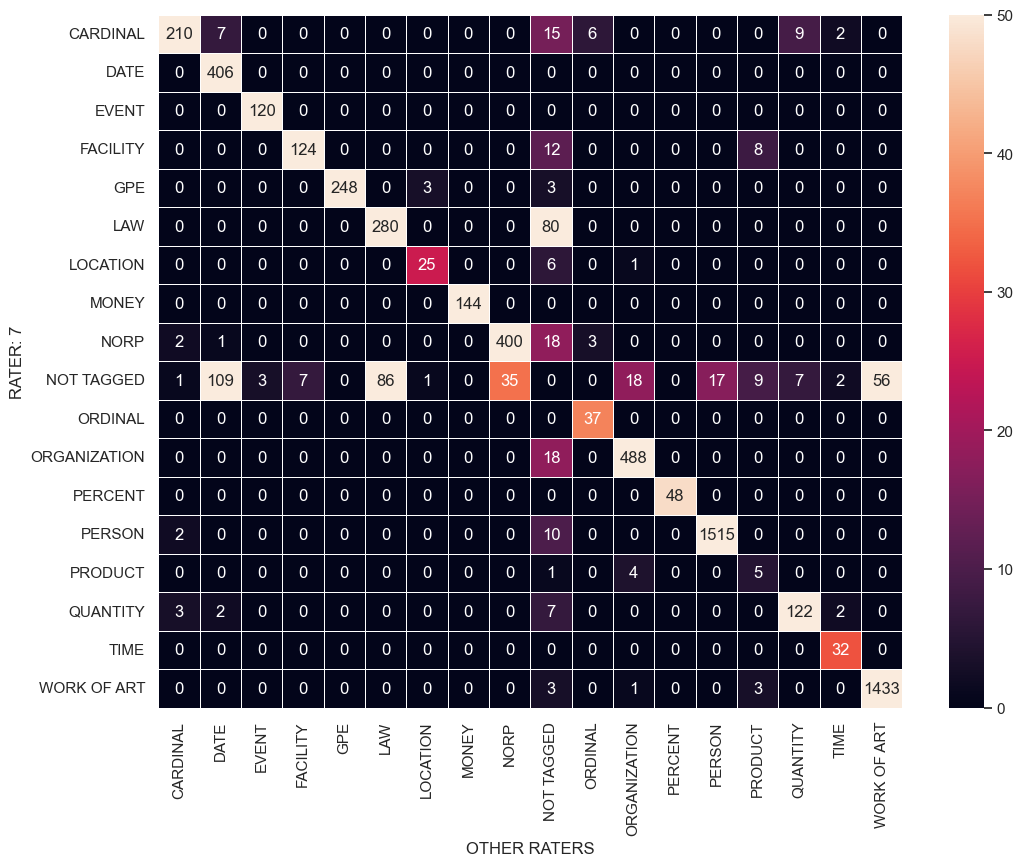

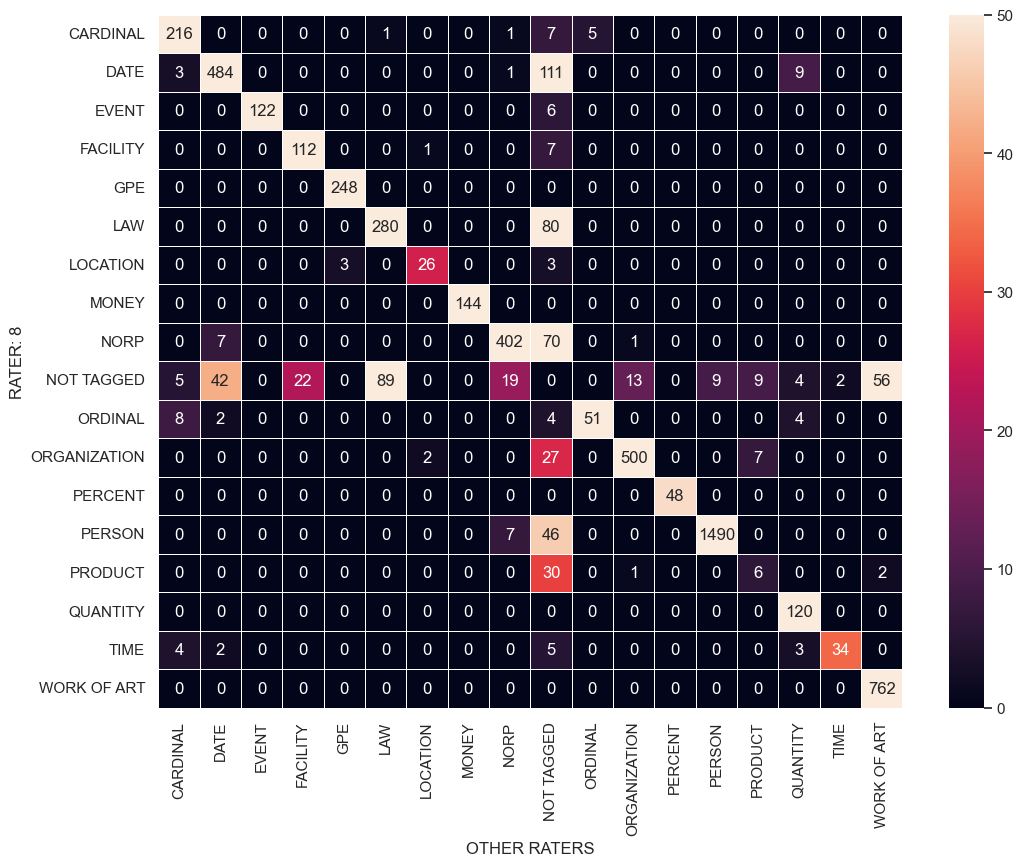

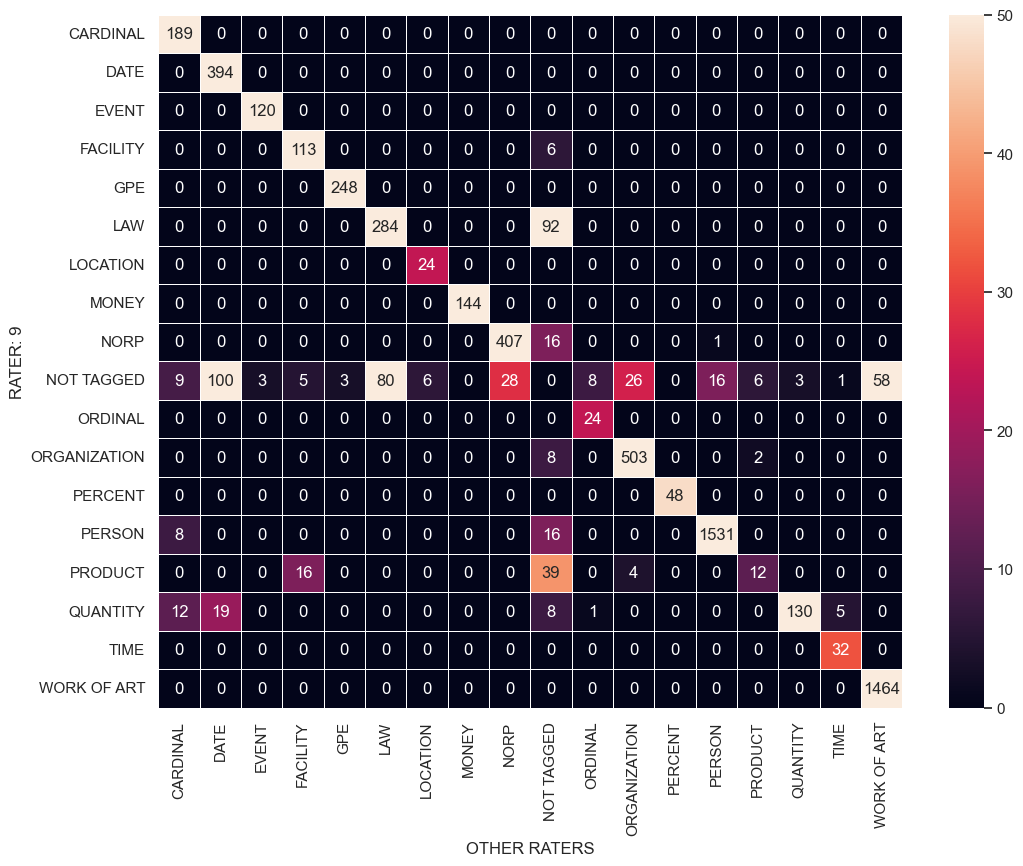

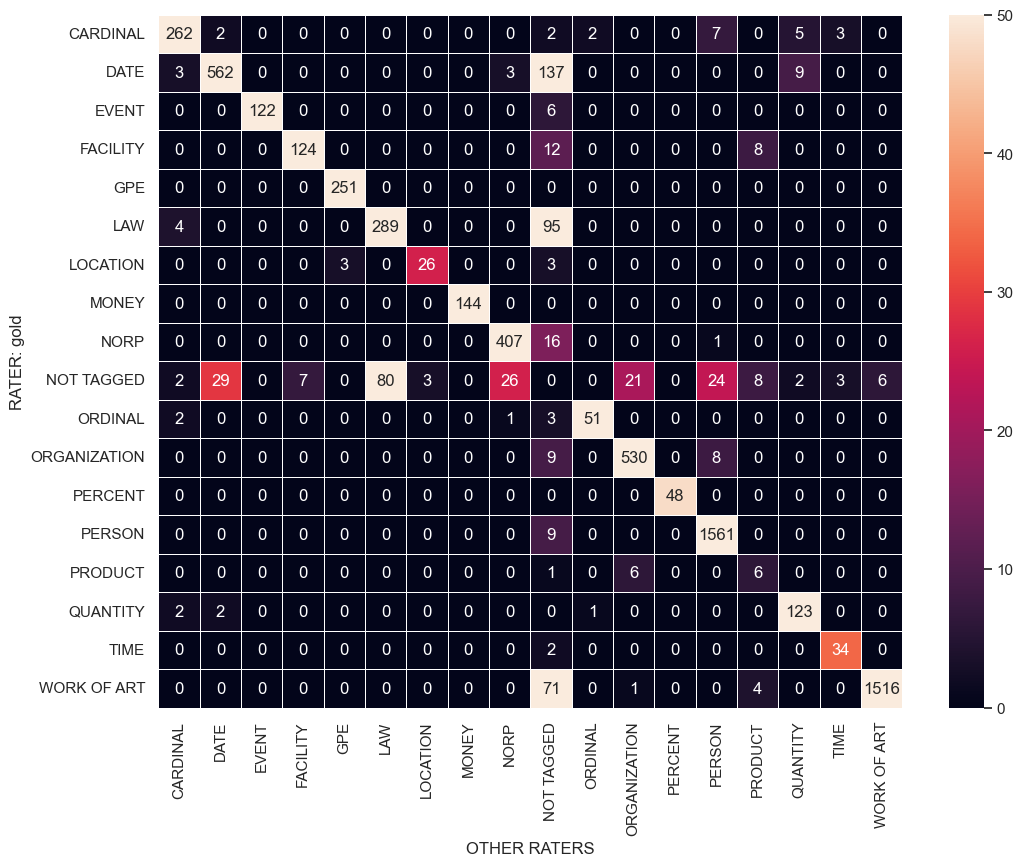

In [195]:
# Make confusion matrix for each rater vs all other raters
sns.set_theme(style='white')
for raterA in range(0, len(raters)):
    # Get the data for raterA
    raterA_data = NERdf_list[raterA].copy()
    # Get the labels for raterA
    labels = sorted(list(set(raterA_data.fillna("NOT TAGGED", inplace=False)["spans_label"].tolist())))

    # List of confusion matrices
    cms = []

    # Get list of other raters, without raterA
    other_raters = list(range(0, len(raters)))
    other_raters.remove(raterA)
    
    # Prepare data for raterB and pair
    for raterB in other_raters:
        raterB_data = NERdf_list[raterB].copy()

        # Merge data
        pair = pd.merge(raterA_data, raterB_data, on=["doc", "tokens_text"], suffixes=["_raterA", "_raterB"])
        # Drop rows where both have NAs
        pair = pair.dropna(subset=["spans_label_raterA", "spans_label_raterB"], how="all")
        # Fill np.nan with NA
        pair["spans_label_raterA"] = pair["spans_label_raterA"].fillna("NOT TAGGED")
        pair["spans_label_raterB"] = pair["spans_label_raterB"].fillna("NOT TAGGED")

        # Create confusion matrix
        # raterA = row(y), raterB = columns(x)
        cm = confusion_matrix(y_true=pair.spans_label_raterA, y_pred=pair.spans_label_raterB, labels=labels)
        cms.append(cm)
        
    # For plot for me
    if raterA == 8:
        cms_gold = cms
        sum_cms_gold = sum(cms)
        
    # Make the sum across all cms
    sum_cms = sum(cms)

    # Make plot
    plt.figure(figsize=(12,9))
    with sns.axes_style("white"):
        s = sns.heatmap(sum_cms, yticklabels=labels, xticklabels=labels, annot=True, linewidths=.5, vmax=50, cbar=True, fmt="g")
        s.set(ylabel=f'RATER: {NERdf_list[raterA]["rater_id"][0]}', xlabel='OTHER RATERS')

In [196]:
dff = pd.DataFrame(sum_cms_gold)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,262,2,0,0,0,0,0,0,0,2,2,0,0,7,0,5,3,0
1,3,562,0,0,0,0,0,0,3,137,0,0,0,0,0,9,0,0
2,0,0,122,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0
3,0,0,0,124,0,0,0,0,0,12,0,0,0,0,8,0,0,0
4,0,0,0,0,251,0,0,0,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,0,289,0,0,0,95,0,0,0,0,0,0,0,0
6,0,0,0,0,3,0,26,0,0,3,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,144,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,407,16,0,0,0,1,0,0,0,0
9,2,29,0,7,0,80,3,0,26,0,0,21,0,24,8,2,3,6


In [269]:
import copy
df = copy.deepcopy(dff)

# Add column
df["LANGUAGE"] = [0] * 18
cols = df.columns.tolist()
cols = cols[:5] + [cols[-1]] + cols[5:-1]
df = df[cols]
new_col_names = ['CARDINAL', 'DATE', 'EVENT', 'FACILITY', 'GPE', 'LANGUAGE', 'LAW', 'LOCATION', 'MONEY', 'NORP', 'NOT TAGGED', 'ORDINAL', 'ORGANIZATION', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK OF ART']
new_col_names.sort()
df = df.set_axis(new_col_names, axis=1, inplace=False)
df.loc[-1] = [0] * 19 # adding a row
df = df.T
new_col_names = ['CARDINAL', 'DATE', 'EVENT', 'FACILITY', 'GPE', 'LAW', 'LOCATION', 'MONEY', 'NORP', 'NOT TAGGED', 'ORDINAL', 'ORGANIZATION', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK OF ART', 'LANGUAGE']
df.columns = new_col_names
cols = df.columns.tolist()
cols = cols[:5] + [cols[-1]] + cols[5:-1]
df = df[cols]
df

/var/folders/gp/42km6q7923n8m4b6vnrz6t_r0000gn/T/ipykernel_1359/807997413.py:11: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(new_col_names, axis=1, inplace=False)


,CARDINAL,DATE,EVENT,FACILITY,GPE,LANGUAGE,LAW,LOCATION,MONEY,NORP,NOT TAGGED,ORDINAL,ORGANIZATION,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK OF ART
CARDINAL,262,3,0,0,0,0,4,0,0,0,2,2,0,0,0,0,2,0,0
DATE,2,562,0,0,0,0,0,0,0,0,29,0,0,0,0,0,2,0,0
EVENT,0,0,122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FACILITY,0,0,0,124,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0
GPE,0,0,0,0,251,0,0,3,0,0,0,0,0,0,0,0,0,0,0
LANGUAGE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LAW,0,0,0,0,0,0,289,0,0,0,80,0,0,0,0,0,0,0,0
LOCATION,0,0,0,0,0,0,0,26,0,0,3,0,0,0,0,0,0,0,0
MONEY,0,0,0,0,0,0,0,0,144,0,0,0,0,0,0,0,0,0,0
NORP,0,3,0,0,0,0,0,0,0,407,26,1,0,0,0,0,0,0,0


In [270]:
df.to_csv("../output/DANSK_final_interrater/conf_matrix_streamlined.csv")